In [ ]:
from pathlib import Path
from tqdm import tqdm
from random import shuffle

## Download dos dados

In [ ]:
!pip install kaggle

In [ ]:
!curl -q -L https://www.kaggle.com/api/v1/datasets/download/borhanitrash/animal-image-classification-dataset -o data.zip
!unzip -q data.zip -d data/
!rm -rf data.zip data/README.md

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 38.3M  100 38.3M    0     0  9064k      0  0:00:04  0:00:04 --:--:-- 12.1M


## Preparo dos Dados

In [ ]:
data_dir = Path("/content/data/Animals")

for folder in data_dir.iterdir():
  print(f"{folder.name}: {len(list(folder.iterdir()))}")


train_dir = data_dir.parent / "train"
test_dir = data_dir.parent / "test"

train_dir.mkdir(exist_ok=True, parents=True)
test_dir.mkdir(exist_ok=True, parents=True)


folder_classes = list(data_dir.iterdir())
for folder_cls in tqdm(folder_classes, total=len(folder_classes)):

    test_dir_cls = test_dir / folder_cls.name
    test_dir_cls.mkdir(exist_ok=True, parents=True)

    train_dir_cls = train_dir / folder_cls.name
    train_dir_cls.mkdir(exist_ok=True, parents=True)

    files = list(folder_cls.glob("*"))
    shuffle(files)
    split_point = int(0.8 * len(files))

    for f in files[:split_point]:
        f.rename(train_dir_cls / f.name)

    for f in files[split_point:]:
        f.rename(test_dir_cls / f.name)


cats: 1000
dogs: 1000
snakes: 1000


100%|██████████| 3/3 [00:00<00:00,  7.05it/s]


In [ ]:
!rm -r /content/data/Animals

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Parâmetros
img_height, img_width = 128, 128
batch_size = 32

# Data augmentation para treino
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

# Somente normalização para teste
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Diretório base
dataset_path = "/content/data"

# Gerador para treino
train_generator = train_datagen.flow_from_directory(
    directory=f"{dataset_path}/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

# Gerador para teste
test_generator = test_datagen.flow_from_directory(
    directory=f"{dataset_path}/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
train_generator.class_indices

{'cats': 0, 'dogs': 1, 'snakes': 2}

## Construção e Treinamento do Modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

def create_tiny_cnn(input_shape=(img_width, img_height, 3)):


    model = Sequential([
        Input(shape=input_shape),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')  # saída binária
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])


    return model

# Exemplo de uso
model = create_tiny_cnn()
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 126, 126, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     6,422,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,793,859 (25.92 MB)

 Trainable params: 6,793,859 (25.92 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(train_generator, validation_data=test_generator, epochs=10)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 184ms/step - accuracy: 0.4056 - loss: 1.1366 - val_accuracy: 0.5383 - val_loss: 0.9787
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - accuracy: 0.5827 - loss: 0.8579 - val_accuracy: 0.6100 - val_loss: 0.7597
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - accuracy: 0.6077 - loss: 0.7997 - val_accuracy: 0.7133 - val_loss: 0.6434
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 170ms/step - accuracy: 0.6531 - loss: 0.7301 - val_accuracy: 0.7117 - val_loss: 0.6683
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 174ms/step - accuracy: 0.6896 - loss: 0.6820 - val_accuracy: 0.5267 - val_loss: 1.1795
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 175ms/step - accuracy: 0.7017 - loss: 0.6715 - val_accuracy: 0.6017 - val_loss: 1.0289
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 20s 172ms/step - accuracy: 0.6907 - loss: 0.6509 - val_accuracy: 0.7483 - val_loss: 0.5856
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 172ms/step - accuracy: 0.6923 - loss: 0.6503 - val_accu

In [ ]:
model.evaluate(test_generator)

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.6802 - loss: 0.6743


[0.5703527927398682, 0.753333330154419]

## Conversão para Tflite FP32

In [ ]:
import tensorflow as tf

# Convert the Keras model to a TFLite model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#save original model

model.save("model.keras")

# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

print("Model converted to TFLite and saved as 'model.tflite'")

## Conversão para Tflite INT8

![Alt text for the image](https://imgs.search.brave.com/XkKXFzF4CLjl8yU7wNX_MlyLP2lCyTNaWSehdq25v00/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9zdWJz/dGFja2Nkbi5jb20v/aW1hZ2UvZmV0Y2gv/JHNfIVIxbzAhLHdf/MTQ1NixjX2xpbWl0/LGZfYXV0byxxX2F1/dG86Z29vZCxmbF9w/cm9ncmVzc2l2ZTpz/dGVlcC9odHRwczov/L3N1YnN0YWNrLXBv/c3QtbWVkaWEuczMu/YW1hem9uYXdzLmNv/bS9wdWJsaWMvaW1h/Z2VzLzczMGJiYjhh/LTNhNDQtNDdmNi1h/ZWZlLWY2NTJiMTE3/YWUyMl8xMTI0eDYw/MC5wbmc)

In [ ]:
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model('model.keras')

def representative_dataset_gen():
    num_samples = 100
    count = 0
    for images, labels in train_generator:
        for image in images:
            if count >= num_samples:
                break
            yield [np.expand_dims(image, axis=0)]
            count += 1
        if count >= num_samples:
            break


converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

quantized_tflite_model = converter.convert()

with open('model_int8.tflite', 'wb') as f:
    f.write(quantized_tflite_model)

print("Model converted to int8 TFLite and saved as 'model_int8.tflite'")

In [ ]:
import os

# Get the size of the original Keras model in bytes
keras_model_size_bytes = os.path.getsize('model.keras')

# Get the size of the TFLite model in bytes
tflite_model_size_bytes = os.path.getsize('model.tflite')

tflite_model_int8_size_bytes = os.path.getsize('model_int8.tflite')

# Convert bytes to MB
keras_model_size_mb = keras_model_size_bytes / (1024 * 1024)
tflite_model_size_mb = tflite_model_size_bytes / (1024 * 1024)
tflite_model_int8_size_mb = tflite_model_int8_size_bytes / (1024 * 1024)

# Calculate percentage decrease
tflite_decrease_percent = ((keras_model_size_bytes - tflite_model_size_bytes) / keras_model_size_bytes) * 100
tflite_int8_decrease_percent = ((keras_model_size_bytes - tflite_model_int8_size_bytes) / keras_model_size_bytes) * 100


print(f"Original Keras model size: {keras_model_size_mb:.2f} MB")
print(f"TFLite model size: {tflite_model_size_mb:.2f} MB ({tflite_decrease_percent:.2f}% decrease)")
print(f"TFLite int8 model size: {tflite_model_int8_size_mb:.2f} MB ({tflite_int8_decrease_percent:.2f}% decrease)")

Original Keras model size: 77.79 MB
TFLite model size: 25.92 MB (66.68% decrease)
TFLite int8 model size: 6.50 MB (91.65% decrease)


## Comparação Entre Keras vs FP32 vs INT8

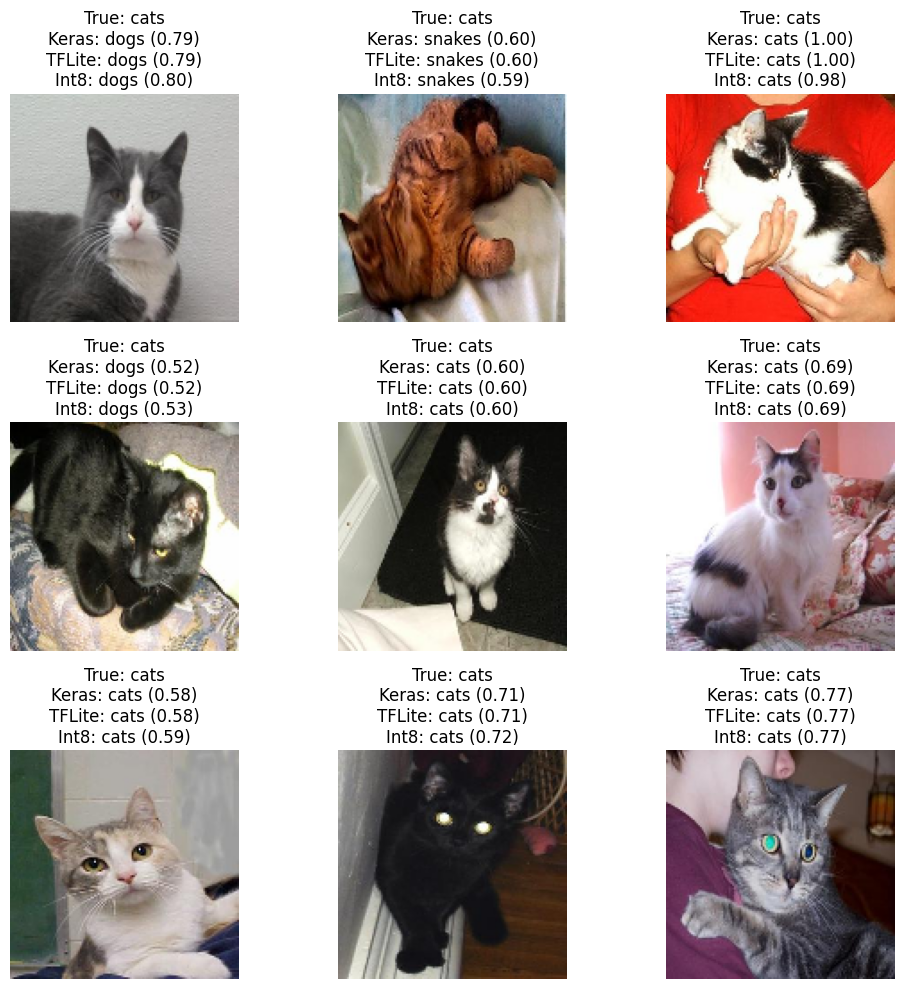

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Load the models
keras_model = tf.keras.models.load_model('models/model.keras')

interpreter_tflite = tf.lite.Interpreter(model_path='models/model.tflite')
interpreter_tflite.allocate_tensors()

interpreter_tflite_int8 = tf.lite.Interpreter(model_path='models/model_int8.tflite')
interpreter_tflite_int8.allocate_tensors()

def predict_with_keras(model, images):
    return model.predict(images, verbose=0)

def predict_with_tflite(interpreter, images):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    preds = []
    for img in images:
        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(img, axis=0))
        interpreter.invoke()
        preds.append(interpreter.get_tensor(output_details[0]['index'])[0])
    return np.array(preds)

def predict_with_tflite_int8(interpreter, images):
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    input_scale, input_zero_point = input_details[0]['quantization']
    output_scale, output_zero_point = output_details[0]['quantization']

    preds = []
    for img in images:
        # Quantize the input image to int8
        img_int8 = (img / input_scale + input_zero_point).astype(np.int8)
        interpreter.set_tensor(input_details[0]['index'], np.expand_dims(img_int8, axis=0))
        interpreter.invoke()
        # Dequantize the output predictions
        output = interpreter.get_tensor(output_details[0]['index'])[0]
        output_float32 = (output.astype(np.float32) - output_zero_point) * output_scale
        preds.append(output_float32)
    return np.array(preds)


# Get a batch of test images and labels
images, labels = next(iter(test_generator))

# Select N random images
N = 9
random_indices = np.random.choice(len(images), N, replace=False)
sample_images = images[random_indices]
sample_labels = labels[random_indices]

# Make predictions with each model
keras_preds = predict_with_keras(keras_model, sample_images)
tflite_preds = predict_with_tflite(interpreter_tflite, sample_images)
tflite_int8_preds = predict_with_tflite_int8(interpreter_tflite_int8, sample_images)


# Get class names
class_names = list(test_generator.class_indices.keys())

# Plot the grid
plt.figure(figsize=(10, 10))
for i in range(N):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[i])
    true_class = class_names[np.argmax(sample_labels[i])]

    keras_pred_class = class_names[np.argmax(keras_preds[i])]
    keras_pred_prob = np.max(keras_preds[i])

    tflite_pred_class = class_names[np.argmax(tflite_preds[i])]
    tflite_pred_prob = np.max(tflite_preds[i])

    tflite_int8_pred_class = class_names[np.argmax(tflite_int8_preds[i])]
    tflite_int8_pred_prob = np.max(tflite_int8_preds[i])


    plt.title(f"True: {true_class}\nKeras: {keras_pred_class} ({keras_pred_prob:.2f})\nTFLite: {tflite_pred_class} ({tflite_pred_prob:.2f})\nInt8: {tflite_int8_pred_class} ({tflite_int8_pred_prob:.2f})")
    plt.axis("off")

plt.tight_layout()
plt.show()